In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# # for dirname, _, filenames in os.walk('/kaggle/input'):
# #     for filename in filenames:
# #         print(os.path.join(dirname, filename))
        

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries
> `OpenCV` is not used.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
#import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'Raw Image')

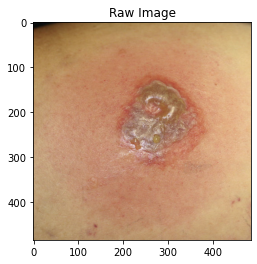

In [7]:

# RashData\Lyme_Positive_By_Diease\EMRash\erythema migrans42.jpg
# img = io.imread("RashData/Validation/Validation_2_Cases/Lyme_Negative/ringworm130.jpg")
img = io.imread("RashData\Lyme_Positive_By_Diease\EMRash\erythema migrans42.jpg")
plt.imshow(img)
plt.title("Raw Image")

Text(0.5, 1.0, 'Resized Image')

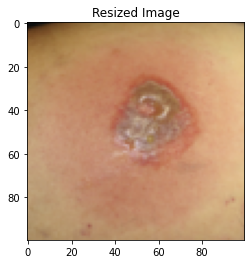

In [8]:
HEIGHT, WIDTH = 100, 100
resized_img = resize(img, (HEIGHT, WIDTH))
plt.imshow(resized_img)
plt.title("Resized Image")

# Importing the data
1. Loading the data from root directory
2. Each image is resized into `200 * 200` dimension
3. The imported image is converted into an numpy array
4. Each data is normalized

In [9]:
# Creating the dataset for processing -- Using SKIMAGE
path_root = "RashData/Train/Train_2_Cases"
data = []
categories = ["Negative", "Positive"]
flag = True
for category in categories:
    path = os.path.join(path_root, "Lyme_" + category)
    label = categories.index(category)
    
    for img in os.listdir(path):
        try:
            img_path = os.path.join(path, img)
            dis_img = io.imread(img_path)
            if flag:
                print(type(dis_img))
                flag = False
    
            image = resize(dis_img, (HEIGHT, WIDTH))
#             image = np.array(dis_img).flatten()
            data.append([image, label])
        except Exception as e:
            print("Could not add image.")

<class 'numpy.ndarray'>


# Spliting the data array into -
* Image Feature Vector(image_ds)
* Corresponding Labels(labels)

In [10]:

image_ds = np.array([obj[0][:,:,0] for obj in data])
labels = np.array([obj[1] for obj in data])
print(image_ds.shape)
#image_ds = image_ds.reshape((356, 200, 200, 1))
len(labels[labels == 1])

(357, 100, 100)


151

# Creating Train and Test Data
> Using 20 percent of data as the test data.

In [11]:
train_x, test_x, train_y, test_y = train_test_split(image_ds, labels, test_size=0.20, shuffle=True)
print("Size of training data:", train_x.shape)
print("Size of test data:", test_x.shape)
len(train_y[train_y==1])

Size of training data: (285, 100, 100)
Size of test data: (72, 100, 100)


121

In [ ]:
# # Creating the dataset for processing
# path_root = "/kaggle/input/lyme-disease-rashes/RashData/Train/Train_2_Cases"
# data = []
# categories = ["Negative", "Positive"]
# flag = True
# for category in categories:
#     path = os.path.join(path_root, "Lyme_" + category)
#     label = categories.index(category)
    
#     for img in os.listdir(path):
#         img_path = os.path.join(path, img)
#         dis_img = cv2.imread(img_path)
#         if flag:
#             print(type(dis_img), dis_img.shape)
#             flag = False
#         try:
#             image = cv2.resize(dis_img, (HEIGHT, WIDTH, 3))
# #             image = np.array(dis_img).flatten()
#             data.append([image, label])
#         except Exception as e:
#             print("Could not add image.")
# print(len(data))
# print(data[0])
# print(data[1])


In [ ]:
# # Normalizing the features
# sc = StandardScaler()
# X_normalized = sc.fit_transform(X)
# print(X_normalized)
# encoder = OneHotEncoder()

# Using Support Vector Machine for Trainning:
1. The training and testing data is flattened
2. Model is defined with a `Polynomial` kernel
3. Model is trained 
4. Confusion Matrix and Classification Report is observed

In [12]:
train_x_flat = train_x.reshape((train_x.shape[0], HEIGHT * WIDTH))
test_x_flat = test_x.reshape((test_x.shape[0], HEIGHT * WIDTH))
print(train_x_flat.shape)
model_svm = SVC(kernel='poly', gamma='auto')
model_svm.fit(train_x_flat, train_y)

(285, 10000)


SVC(gamma='auto', kernel='poly')

In [13]:
pred_y = model_svm.predict(test_x_flat)
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

[[42  0]
 [30  0]]
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        42
           1       0.00      0.00      0.00        30

    accuracy                           0.58        72
   macro avg       0.29      0.50      0.37        72
weighted avg       0.34      0.58      0.43        72



# Using Deep Feed Forward Network to train
+ Using a fully connected network to train 
+ The network consists of two hidden layer of size `20000 * 1`
+ Finally using a output layer with `sigmoid` activation as it is binary classification
> Assuming the input images are of dimension `100 * 100`.

In [17]:
model_dense = keras.models.Sequential([
    keras.Input(shape=(100 * 100,)),
    keras.layers.Dense(2 * 100 * 100, activation='relu'),
    keras.layers.Dense(2 * 100 * 100, activation='relu'),
    keras.layers.Dense(1)
])
model_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dense.fit(train_x_flat, train_y, batch_size=32, epochs=20,steps_per_epoch=4)

KeyboardInterrupt: 

In [18]:
report = model_dense.evaluate(test_x_flat, test_y)
print(report)

3/3 [==============================] - 6s 355ms/step - loss: 6.4271 - accuracy: 0.5833
[6.427061557769775, 0.5833333134651184]


# Using CNN to train
This is executed in following steps:
1. First we rescale the training and validation data in range `[0, 1]`
2. Then we define 5 convolution layers with MaxPool layers and `relu` activation
3. Last output layer is of size 1 and using `sigmoid` activation function

In [38]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

train_ds = train.flow_from_directory("RashData/Train/Train_2_Cases", target_size=(HEIGHT, WIDTH),
                                    batch_size=10, class_mode='binary')
val_ds = validation.flow_from_directory("RashData/Validation/Validation_2_Cases", target_size=(HEIGHT, WIDTH),
                                       batch_size=10, class_mode='binary')
val_ds.class_indices
filter_size = (2, 2)
epochs = 40

Found 357 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [39]:
model_conv_2d = keras.models.Sequential([
    keras.layers.Conv2D(32, filter_size, activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(64, filter_size, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(128, filter_size, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(256, filter_size, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(512, filter_size, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [40]:
model_conv_2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_conv_2d.fit(train_ds, steps_per_epoch=3, epochs=epochs, validation_data=val_ds)

Epoch 1/40
3/3 [==============================] - 2s 594ms/step - loss: 7.9203 - accuracy: 0.4667 - val_loss: 0.6825 - val_accuracy: 0.5862
Epoch 2/40
3/3 [==============================] - 1s 470ms/step - loss: 2.3928 - accuracy: 0.6000 - val_loss: 0.6868 - val_accuracy: 0.5977
Epoch 3/40
3/3 [==============================] - 2s 908ms/step - loss: 1.5621 - accuracy: 0.5667 - val_loss: 0.6865 - val_accuracy: 0.5862
Epoch 4/40
3/3 [==============================] - 1s 442ms/step - loss: 1.5417 - accuracy: 0.7333 - val_loss: 0.7251 - val_accuracy: 0.5862
Epoch 5/40
3/3 [==============================] - 1s 435ms/step - loss: 1.5873 - accuracy: 0.6667 - val_loss: 0.9314 - val_accuracy: 0.5862
Epoch 6/40
3/3 [==============================] - 2s 918ms/step - loss: 3.1714 - accuracy: 0.4667 - val_loss: 0.8688 - val_accuracy: 0.5862
Epoch 7/40
3/3 [==============================] - 2s 732ms/step - loss: 1.6172 - accuracy: 0.7000 - val_loss: 0.6881 - val_accuracy: 0.5862
Epoch 8/40
3/3 [====

In [41]:
plt.figure(figsize=(20, 10))

epochs_range = range(1, epochs + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_auc, label="Training AUC", color='b')
plt.plot(epochs_range, val_auc, label="Validation AUC", color='r')

plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training and Validation AUC")
plt.legend()

plt.show()

KeyError: 'auc'

<Figure size 1440x720 with 0 Axes>

In [16]:
# model_conv_3d = keras.models.Sequential([
#     keras.layers.Conv3D(8, (3, 3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
#     keras.layers.AveragePooling3D(pool_size=(2, 2, 2)),
#     keras.layers.Conv3D(16, (3, 3, 3), activation='relu'),
#     keras.layers.AveragePooling3D(pool_size=(2, 2, 2)),
#     keras.layers.Conv3D(32, (3, 3, 3), activation='relu'),
#     keras.layers.AveragePooling3D(pool_size=(2, 2, 2)),
#     keras.layers.Conv3D(64, (3, 3, 3), activation='relu'),
#     keras.layers.AveragePooling3D(pool_size=(2, 2, 2)),
#     keras.layers.Conv3D(128, (3, 3, 3), activation='relu'),
#     keras.layers.AveragePooling3D(pool_size=(2, 2, 2)),
#     keras.layers.Flatten(),
#     keras.layers.Dense(1024, activation='relu'),
#     keras.layers.Dense(1, activation='sigmoid')
# ])